In [3]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

In [120]:
from datetime import datetime, timedelta

# Range date 3 years 
end_date = datetime(2025, 7, 27)
start_date = end_date - timedelta(days=3*365)

# Date List
dates = [
    f"{(start_date + timedelta(days=i)).year}-{(start_date + timedelta(days=i)).month}-{(start_date + timedelta(days=i)).day}"
    for i in range((end_date - start_date).days + 1)
]

In [5]:
!pip install ipywidgets --quiet

In [607]:
base_url = "https://horoskopy.gazeta.pl/horoskop/ryby/dzienny/"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0 Safari/537.36'
}

data = []

for date in tqdm(dates):
    url = base_url + date
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        try:
            horoskop_text = soup.find("p", class_="lead").get_text(strip=True)
        except AttributeError:
            horoskop_text = None
    else:
        horoskop_text = None

    data.append({'date': date, 'horoscope': horoskop_text})



100%|██████████| 1096/1096 [07:33<00:00,  2.41it/s]


In [608]:
df = pd.DataFrame(data)
df['date'] = pd.to_datetime(df['date'])
df = df.dropna().reset_index(drop=True)

# Save
df.to_excel("horoscope_pisces_3years.xlsx", index=False)
df.head()

,date,horoscope
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...


In [609]:
# Read
df = pd.read_excel('horoscope_pisces_3years.xlsx')

In [610]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from deep_translator import GoogleTranslator

# Initialization of sentiment analyzer and translator
analyzer = SentimentIntensityAnalyzer()
translator = GoogleTranslator(source='pl', target='en')

# Translating and analyzing function
def translate_and_analyze(text):
    try:
        translated = translator.translate(text)
        sentiment = analyzer.polarity_scores(translated)
        return translated, sentiment['compound']
    except Exception as e:
        print("Error:", e)
        return None, None

# Applying the function and unpacking into two columns
df[['translated_text', 'sentiment_score']] = df['horoscope'].apply(
    lambda x: pd.Series(translate_and_analyze(x))
)

# Categorization of the result
def classify_sentiment(score):
    if score is None:
        return 'unknown'
    elif score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_label'] = df['sentiment_score'].apply(classify_sentiment)

Error: Rybo, skup się bardziej na swoim budżecie. Pomyśl, w jaki sposób możesz lepiej planować swoje wydatki, by w razie nadłych zdarzeń nie wpadać w panikę. Czasem lepiej zamiast na kolejne zakupy wybrać się np. do parku na spacer. --> No translation was found using the current translator. Try another translator?
Error: Rybo, gwiazdy sprzyjają Ci dzisiaj w miłości. Wykorzystaj to, jeśli jesteś na etapie poszukiwań swojej drugiej połówki. Masz dzisiaj szansę na poznanie kogoś ciekawego, z kim mogłabyś lub mógłbyś stworzyć udaną relację. --> No translation was found using the current translator. Try another translator?


In [569]:
len(df)

1091

In [611]:
# Save
df.to_excel("horoscope_pisces_3years_new.xlsx", index=False)
df.head()

,date,horoscope,translated_text,sentiment_score,sentiment_label
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive


In [527]:
from transformers import pipeline

In [612]:
# Read
df = pd.read_excel('horoscope_pisces_3years_new.xlsx')

In [613]:
# Hugging Face pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

# Test
df_subset = df.head(1090).copy()

# Tłumaczenie i analiza
def translate_and_classify(text):
    try:
        translated = GoogleTranslator(source='pl', target='en').translate(text)
        sentiment = sentiment_pipeline(translated)[0]['label']
        return sentiment
    except Exception as e:
        print("Error:", e)
        return 'unknown'

df_subset['hf_sentiment'] = df_subset['horoscope'].apply(translate_and_classify)

# Results
print(df_subset['hf_sentiment'].value_counts())

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cpu


hf_sentiment
POS    596
NEU    398
NEG     96
Name: count, dtype: int64


In [614]:
# Save
df_subset.to_excel("horoscope_pisces_3years_hf.xlsx", index=False)
df_subset.head()

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS


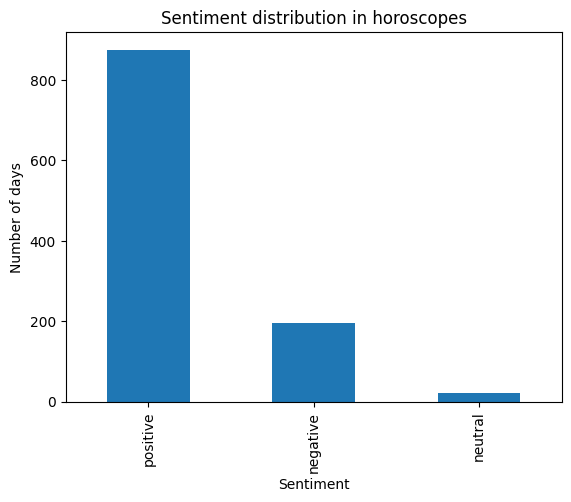

In [615]:
import matplotlib.pyplot as plt

df['sentiment_label'].value_counts().plot(kind='bar', title='Sentiment distribution in horoscopes')
plt.xlabel('Sentiment')
plt.ylabel('Number of days')
plt.show()


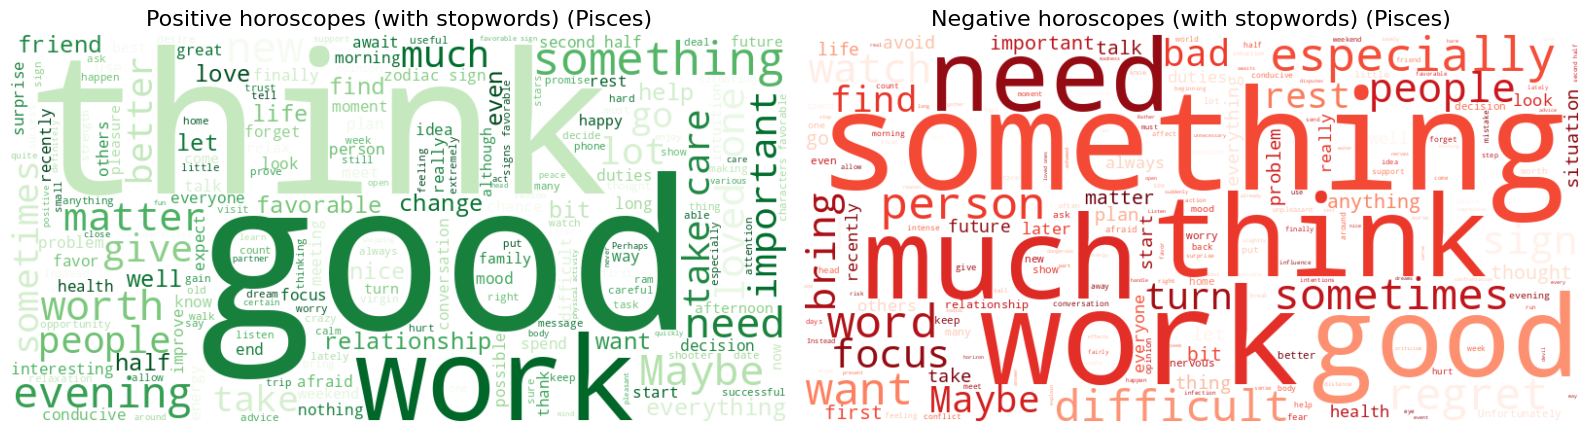

In [617]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['Fish','Rybo','Pisces','pisces','Sheep','aries','Aries','Miss','virgo','Virgo','Raku','cancer','Cancer','weight','Wago','libra','Libra','Bull','feel','Bulls','taurus','Taurus','aquarius','Aquarius','scorpio','Scorpio','Scorpion','Scorpions','may','make','Strzelec','Strzelce','Remember','Capricorn','Sagittarius','sagittarius','Lion','Gemini','Twin','twins','Lions', 'today', 'will', 'day', 'time', 'someone', 'try'])

# Text segmentation
positive_texts = " ".join(df[df['sentiment_label'] == 'positive']['translated_text'].tolist())
negative_texts = " ".join(df[df['sentiment_label'] == 'negative']['translated_text'].tolist())

# Creating WordClouds using custom stopwords
wordcloud_pos = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Greens').generate(positive_texts)

wordcloud_neg = WordCloud(width=800, height=400, background_color='white',
                          stopwords=custom_stopwords, colormap='Reds').generate(negative_texts)

# Visualization
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive horoscopes (with stopwords) (Pisces)', fontsize=16)

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative horoscopes (with stopwords) (Pisces)', fontsize=16)

plt.tight_layout()
plt.savefig("Pisces_wordclouds.png", dpi=300) 
plt.show()


In [619]:
df=df_subset

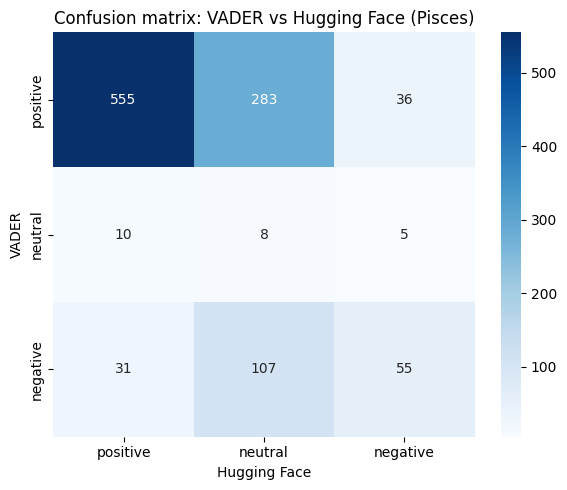

In [620]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Mapping hf_sentiment to full names
hf_map = {
    'POS': 'positive',
    'NEU': 'neutral',
    'NEG': 'negative'
}
df['hf_sentiment_full'] = df['hf_sentiment'].map(hf_map)

# Remove NaN values and ensure all labels are strings
df = df.dropna(subset=['sentiment_label', 'hf_sentiment'])
df['sentiment_label'] = df['sentiment_label'].astype(str)
df['hf_sentiment_full'] = df['hf_sentiment'].map(hf_map).astype(str)

# Confusion matrix
cm = confusion_matrix(df['sentiment_label'], df['hf_sentiment_full'], labels=['positive', 'neutral', 'negative'])

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['positive', 'neutral', 'negative'],
            yticklabels=['positive', 'neutral', 'negative'])
plt.xlabel("Hugging Face")
plt.ylabel("VADER")
plt.title("Confusion matrix: VADER vs Hugging Face (Pisces)")
plt.tight_layout()
plt.savefig("pisces_confusion_matrix.png", dpi=300) 
plt.show()



In [621]:
df

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,hf_sentiment_full
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,positive
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,positive
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,negative
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,neutral
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,positive
...,...,...,...,...,...,...,...
1085,2025-07-20,"Rybo, dziś możesz narzekać na swoje samopoczuc...","Fish, today you can complain about your well -...",0.0258,neutral,NEU,neutral
1086,2025-07-21,"Rybo, usłyszysz dziś nieocenioną radę, od osob...","Rybo, you will hear an invaluable advice today...",0.8360,positive,POS,positive
1087,2025-07-22,"Rybo, dziś bądź czujna. Usłyszysz pewną nieoce...","Fish, be alert today. You will hear some inval...",0.4289,positive,POS,positive
1088,2025-07-23,"Rybo, ktoś w Twoim otoczeniu może potrzebować ...","Fish, someone around you may need support. A d...",0.9325,positive,NEU,neutral


In [1]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction import text

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pmiro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [622]:
def clean_text(text):
    if not isinstance(text, str):
        return "" 
    text = re.sub(r'[^\w\s]', '', text.lower())
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

In [623]:
df['clean_text'] = df['translated_text'].apply(clean_text)

In [624]:
df

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,hf_sentiment_full,clean_text
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,positive,fish fulfill dreams desires lack intuition pun...
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,positive,fish full strength energy morning day favors i...
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,negative,fish feel little weakened day conducive starti...
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,neutral,fish reluctant new matters acquaintances becom...
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,positive,fish embrace rebellious mood pretext youll get...
...,...,...,...,...,...,...,...,...
1085,2025-07-20,"Rybo, dziś możesz narzekać na swoje samopoczuc...","Fish, today you can complain about your well -...",0.0258,neutral,NEU,neutral,fish today complain well instead worrying take...
1086,2025-07-21,"Rybo, usłyszysz dziś nieocenioną radę, od osob...","Rybo, you will hear an invaluable advice today...",0.8360,positive,POS,positive,rybo hear invaluable advice today person undou...
1087,2025-07-22,"Rybo, dziś bądź czujna. Usłyszysz pewną nieoce...","Fish, be alert today. You will hear some inval...",0.4289,positive,POS,positive,fish alert today hear invaluable advice initia...
1088,2025-07-23,"Rybo, ktoś w Twoim otoczeniu może potrzebować ...","Fish, someone around you may need support. A d...",0.9325,positive,NEU,neutral,fish someone around may need support delicate ...


In [625]:
# Convert to list
vectorizer = TfidfVectorizer(
    ngram_range=(2, 2),
    stop_words=list(stop_words),  
    min_df=3,
    max_df=0.95
)

# Transformation
tfidf_matrix = vectorizer.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
tfidf_df['hf_sentiment_full'] = df['hf_sentiment_full'].values

In [626]:
tfidf_df.head(10)

,able interrupt,achieve goals,achieve success,across dishonest,action plan,activity weekend,add additional,additional dose,additional tasks,advance free,...,worth thinking,would like,would work,years ago,youll feel,youll get,youve neglected,zodiac sign,zodiac signs,hf_sentiment_full
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.283648,0.00000,positive
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.219806,0.00000,positive
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.247563,0.00000,negative
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,neutral
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.410322,0.0,0.260043,0.00000,positive
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,neutral
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.214383,0.00000,neutral
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.373493,0.00000,neutral
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.290001,0.00000,neutral
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.34066,positive


In [627]:
def top_bigrams_per_label(label, top_n=10):
    class_rows = tfidf_df[tfidf_df['hf_sentiment_full'] == label].drop(columns='hf_sentiment_full')
    mean_scores = class_rows.mean().sort_values(ascending=False).head(top_n)
    print(f"\nTop {top_n} bigrams for {label}:")
    for phrase, score in mean_scores.items():
        print(f"{phrase} ({score:.4f})")

In [628]:
top_bigrams_per_label('negative')   # Negative horoscope
top_bigrams_per_label('neutral')  # Neutral horoscope
top_bigrams_per_label('positive')  # Positive horoscope


Top 10 bigrams for negative:
fish watch (0.0493)
loved ones (0.0404)
better talk (0.0210)
fish feel (0.0204)
today unfortunately (0.0197)
regret later (0.0191)
rybo today (0.0188)
fish bit (0.0185)
rybo recently (0.0184)
watch words (0.0184)

Top 10 bigrams for neutral:
loved ones (0.0202)
take care (0.0199)
however try (0.0152)
rybo today (0.0151)
fish feel (0.0143)
fish dont (0.0141)
fish today (0.0138)
half day (0.0138)
fish remember (0.0129)
second half (0.0119)

Top 10 bigrams for positive:
rybo today (0.0317)
take care (0.0206)
loved ones (0.0199)
dont afraid (0.0162)
fish today (0.0160)
zodiac sign (0.0147)
long time (0.0144)
half day (0.0127)
second half (0.0121)
good day (0.0118)


In [629]:
df['date'] = pd.to_datetime(df['date'])

# 'Date' as index
df.set_index('date', inplace=True)

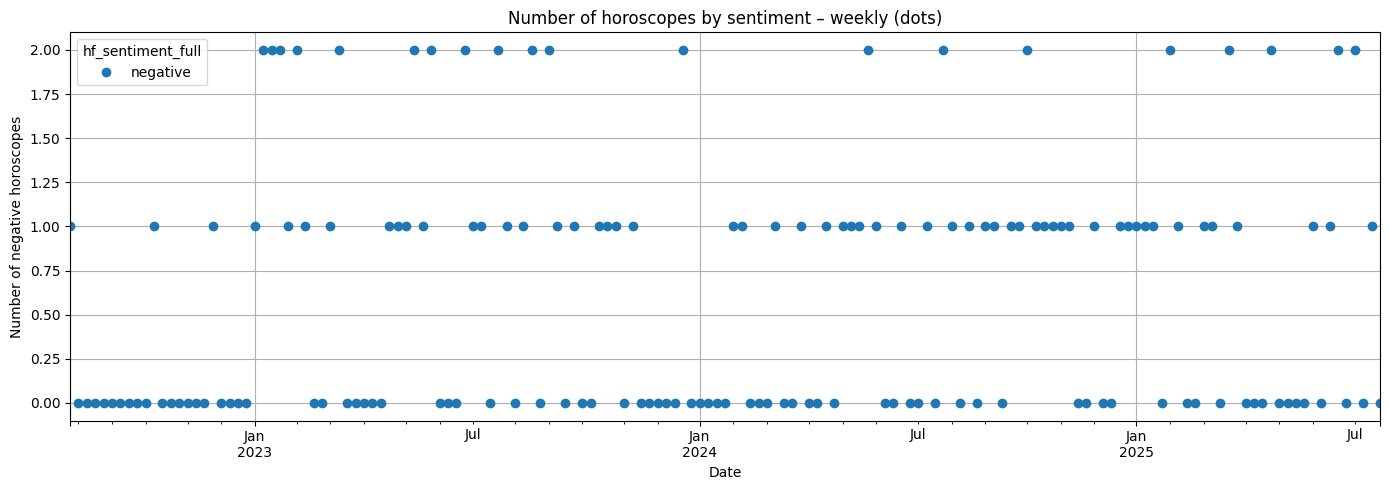

In [630]:
weekly_sentiment = (
    df.groupby([pd.Grouper(freq='W'), 'hf_sentiment_full'])
      .size()
      .unstack(fill_value=0)
)

weekly_sentiment[['negative']].plot(
    figsize=(14, 5), 
    style=['o', 'o', 'o'],  # same kropki, bez linii
    markersize=6,
    grid=True
)

plt.title("Number of horoscopes by sentiment – weekly (dots)")
plt.xlabel("Date")
plt.ylabel("Number of negative horoscopes")
plt.tight_layout()
plt.show()




C:\Users\pmiro\AppData\Local\Temp\ipykernel_32136\3979129097.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.groupby([pd.Grouper(freq='M'), 'hf_sentiment_full'])


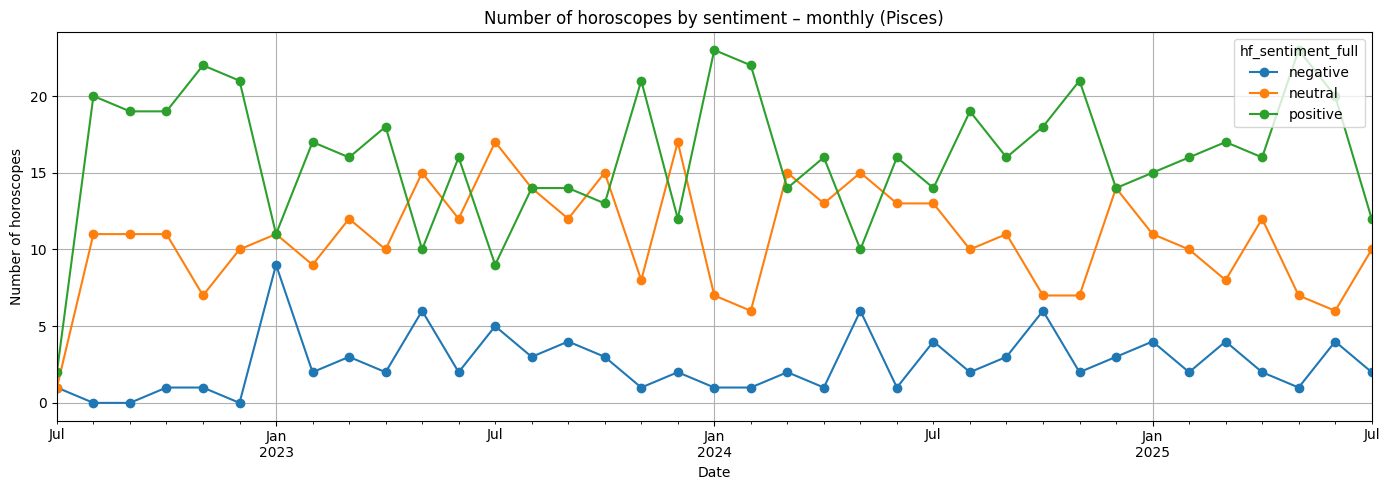

In [631]:
monthly_sentiment = (
    df.groupby([pd.Grouper(freq='M'), 'hf_sentiment_full'])
      .size()
      .unstack(fill_value=0)
)

monthly_sentiment[['negative', 'neutral', 'positive']].plot(figsize=(14, 5), marker='o')
plt.title("Number of horoscopes by sentiment – monthly (Pisces)")
plt.xlabel("Date")
plt.ylabel("Number of horoscopes")
plt.grid(True)
plt.tight_layout()
plt.savefig("pisces_monthly_sentiment.png", dpi=300)  
plt.show()


In [5]:
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [80]:
# 🧾 Wczytaj dane 
files = ["horoscope_pisces_3years_hf.xlsx","horoscope_aries_3years_hf.xlsx","horoscope_virgo_3years_hf.xlsx",
         "horoscope_cancer_3years_hf.xlsx","horoscope_libra_3years_hf.xlsx","horoscope_taurus_3years_hf.xlsx",
         "horoscope_aquarius_3years_hf.xlsx","horoscope_scorpio_3years_hf.xlsx","horoscope_sagittarius_3years_hf.xlsx",
         "horoscope_leo_3years_hf.xlsx",
         "horoscope_gemini_3years_hf.xlsx", "horoskopy_koziorozec_3lata_hf.xlsx"]

source_map = {
    "horoscope_leo_3years_hf.xlsx": "Leo",
    "horoskopy_koziorozec_3lata_hf.xlsx": "Capricorn",
    "horoscope_gemini_3years_hf.xlsx": "Gemini",
    "horoscope_sagittarius_3years_hf.xlsx": "Sagittarius",
    "horoscope_scorpio_3years_hf.xlsx": "Scorpio",
    "horoscope_aquarius_3years_hf.xlsx": "Aquarius",
    "horoscope_taurus_3years_hf.xlsx": "Taurus",
    "horoscope_libra_3years_hf.xlsx": "Libra",
    "horoscope_cancer_3years_hf.xlsx": "Cancer",
    "horoscope_virgo_3years_hf.xlsx": "Virgo",
    "horoscope_aries_3years_hf.xlsx": "Aries",
    "horoscope_pisces_3years_hf.xlsx": "Pisces"
}

df_concat = pd.concat(
    [pd.read_excel(f).assign(source=source_map[f]) for f in files],
    ignore_index=True
)

In [82]:
df_concat

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,source
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,Pisces
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,Pisces
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,Pisces
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,Pisces
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,Pisces
...,...,...,...,...,...,...,...
13075,2025-07-22,"Koziorożcu, pamiętaj, że lepsza jest szczera p...","Capricorn, remember that honest truth is bette...",0.9571,positive,POS,Capricorn
13076,2025-07-23,"Koziorożcu, poczujesz się dziś nieco osamotnio...","Capricorn, you will feel a bit lonely today. T...",-0.4621,negative,NEU,Capricorn
13077,2025-07-24,"Koziorożcu, nie przejmuj się opiniami innych i...","Capricorn, do not worry about the opinions of ...",0.0767,positive,POS,Capricorn
13078,2025-07-25,"Koziorożcu, dziś będziesz bardzo ciekawski, a ...","Capricorn, today you will be very curious, and...",-0.3723,negative,NEG,Capricorn


In [84]:
# upewniamy się, że kolumna data jest typu datetime
df_concat["date"] = pd.to_datetime(df_concat["date"], errors='coerce')

In [15]:
# Save
df_concat.to_excel("horoscope_all_3years.xlsx", index=False)
df_concat.head()

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,source
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,Pisces
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,Pisces
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,Pisces
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,Pisces
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,Pisces


In [86]:
# Mapping hf_sentiment to full names
hf_map = {
    'POS': 'positive',
    'NEU': 'neutral',
    'NEG': 'negative'
}
df_concat['hf_sentiment_full'] = df_concat['hf_sentiment'].map(hf_map)

# Remove NaN values and ensure all labels are strings
df_concat['hf_sentiment_full'] = df_concat['hf_sentiment'].map(hf_map).astype(str)

In [88]:
df_concat

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,source,hf_sentiment_full
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,Pisces,positive
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,Pisces,positive
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,Pisces,negative
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,Pisces,neutral
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,Pisces,positive
...,...,...,...,...,...,...,...,...
13075,2025-07-22,"Koziorożcu, pamiętaj, że lepsza jest szczera p...","Capricorn, remember that honest truth is bette...",0.9571,positive,POS,Capricorn,positive
13076,2025-07-23,"Koziorożcu, poczujesz się dziś nieco osamotnio...","Capricorn, you will feel a bit lonely today. T...",-0.4621,negative,NEU,Capricorn,neutral
13077,2025-07-24,"Koziorożcu, nie przejmuj się opiniami innych i...","Capricorn, do not worry about the opinions of ...",0.0767,positive,POS,Capricorn,positive
13078,2025-07-25,"Koziorożcu, dziś będziesz bardzo ciekawski, a ...","Capricorn, today you will be very curious, and...",-0.3723,negative,NEG,Capricorn,negative


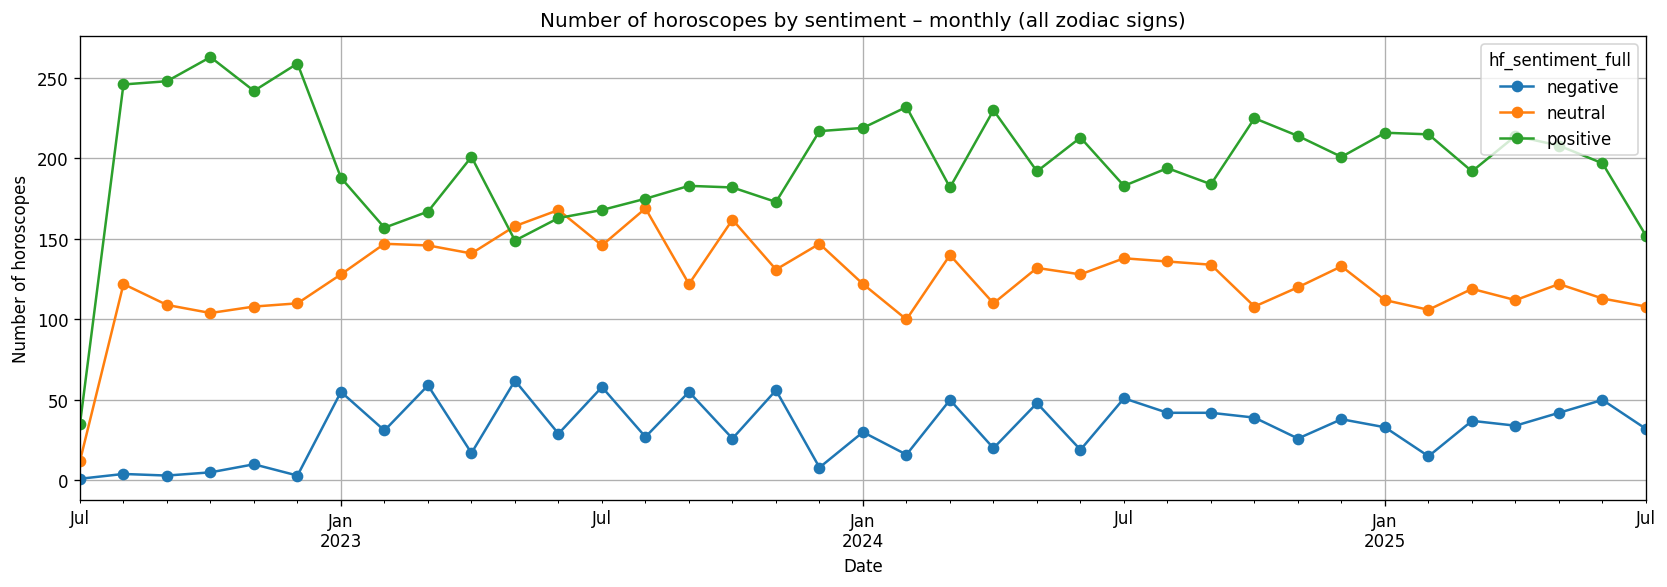

In [98]:
df_concat['date'] = pd.to_datetime(df_concat['date'])

monthly_sentiment_all = (
    df_concat
      .groupby([pd.Grouper(key='date', freq='ME'), 'hf_sentiment_full'])
      .size()
      .unstack(fill_value=0)
      .sort_index()
)

monthly_sentiment_all = monthly_sentiment_all.reindex(
    columns=['negative', 'neutral', 'positive'],
    fill_value=0
)

full_months = pd.date_range(
    monthly_sentiment_all.index.min(),
    monthly_sentiment_all.index.max(),
    freq='ME'
)
monthly_sentiment_all = monthly_sentiment_all.reindex(full_months, fill_value=0)

ax = monthly_sentiment_all[['negative', 'neutral', 'positive']].plot(figsize=(14, 5), marker='o')
ax.set_title("Number of horoscopes by sentiment – monthly (all zodiac signs)")
ax.set_xlabel("Date")
ax.set_ylabel("Number of horoscopes")
ax.grid(True)
plt.tight_layout()
plt.savefig("all_monthly_sentiment.png", dpi=300)
plt.show()


In [17]:
# Filtering positive entries
df_pos = df_concat[df_concat["hf_sentiment"] == "POS"]

In [19]:
# Filtering negative entries
df_neg = df_concat[df_concat["hf_sentiment"] == "NEG"]

In [21]:
# Grouping by sign and time
freq = 'ME'
grouped = (
    df_pos
    .groupby(["source", pd.Grouper(key="date", freq=freq)])
    .size()
    .reset_index(name="liczba_pozytywnych")
)


In [23]:
# Grouping by sign and time
freq = 'ME'  
grouped_neg = (
    df_neg
    .groupby(["source", pd.Grouper(key="date", freq=freq)])
    .size()
    .reset_index(name="liczba_negatywnych")
)


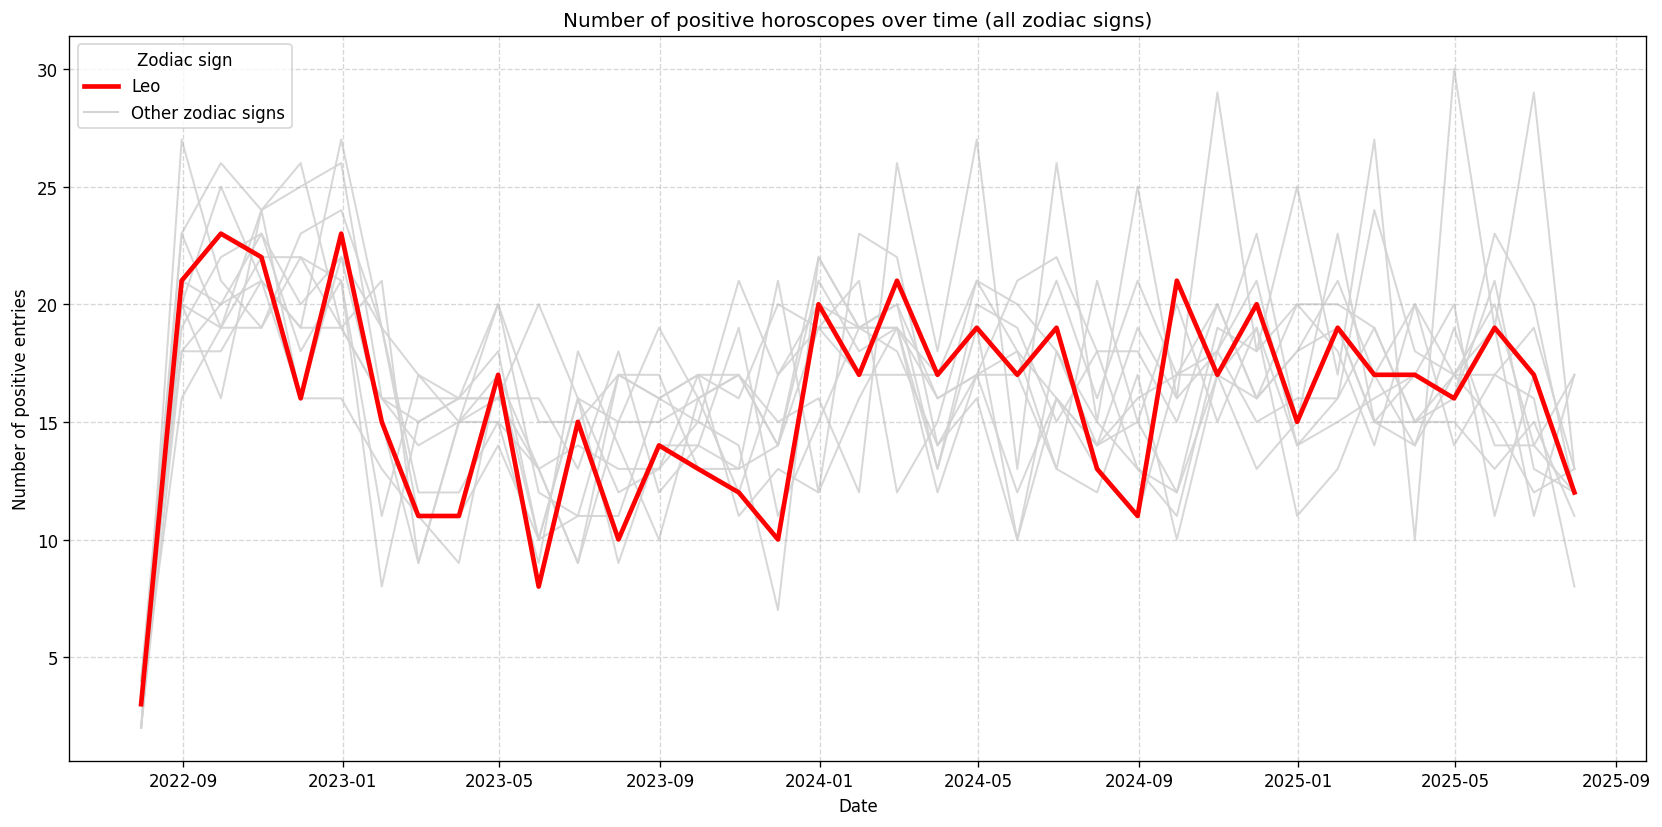

In [66]:
# Pivot & line chart 
pivot_df = grouped.pivot(index="date", columns="source", values="liczba_pozytywnych").fillna(0)

highlight_sign = "Leo"

plt.figure(figsize=(14, 7))

for col in pivot_df.columns:
    if str(col).lower() == highlight_sign.lower():
        # highlighted line (Leo)
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=2.8, color='red', zorder=3, label=str(col)
        )
    else:
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=1.2, color='lightgray', alpha=0.9, zorder=1
        )

plt.title("Number of positive horoscopes over time (all zodiac signs)")
plt.xlabel("Date")
plt.ylabel("Number of positive entries")
plt.grid(True, linestyle="--", alpha=0.5)

# legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2.8, label=highlight_sign),
    Line2D([0], [0], color='lightgray', linewidth=1.2, label='Other zodiac signs')
]
plt.legend(handles=legend_elements, title="Zodiac sign")

plt.tight_layout()
plt.savefig("leo_vs_other_signs_positive.png", dpi=300)  
plt.show()


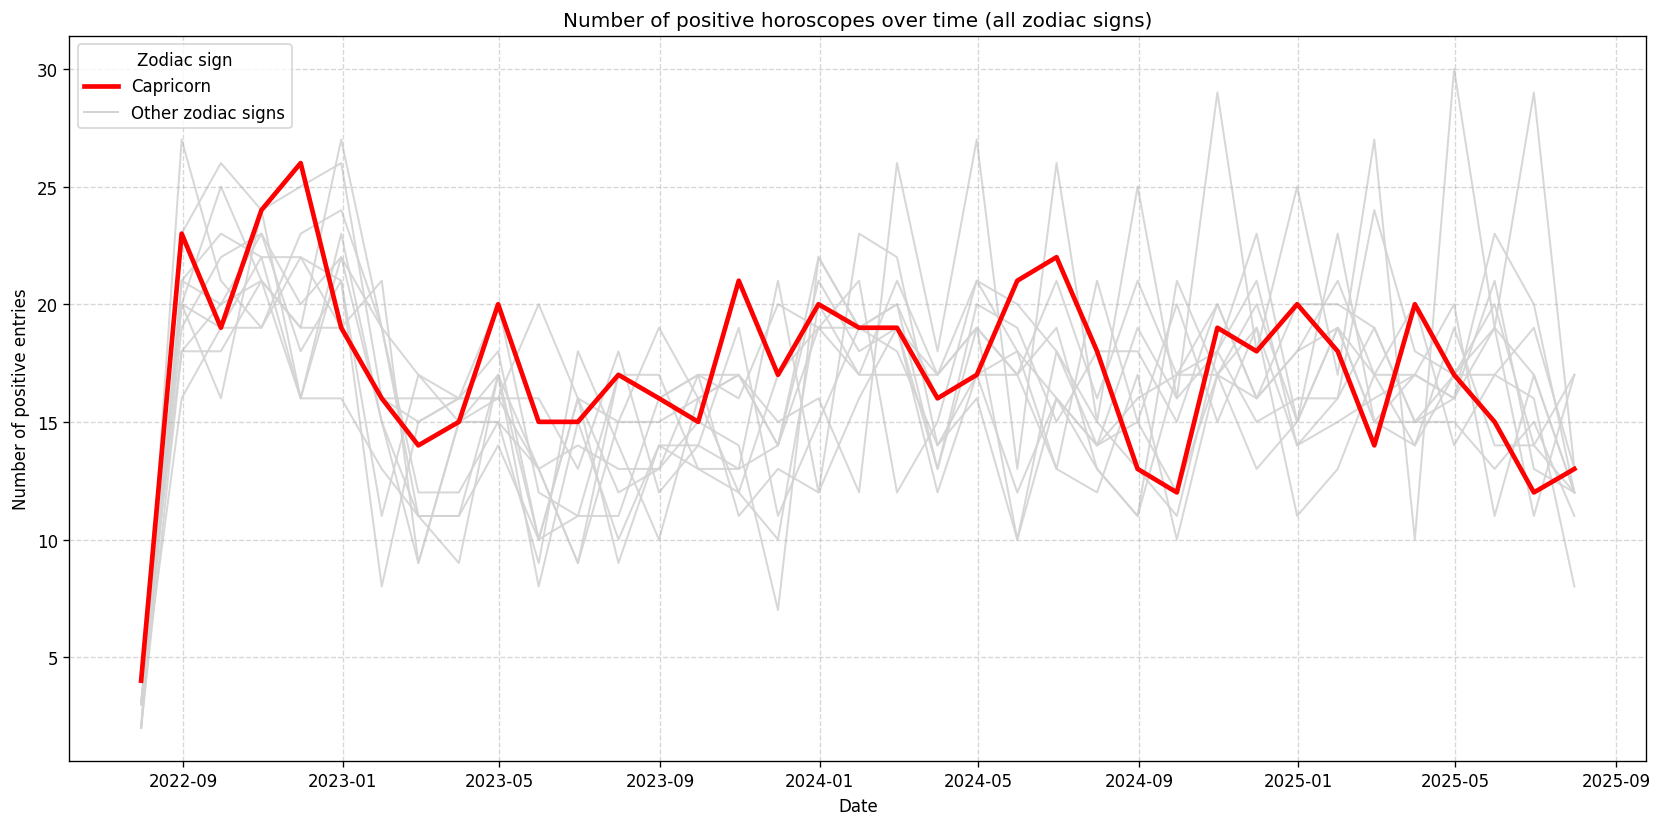

In [68]:
# Pivot & line chart 
pivot_df = grouped.pivot(index="date", columns="source", values="liczba_pozytywnych").fillna(0)

highlight_sign = "Capricorn"

plt.figure(figsize=(14, 7))

for col in pivot_df.columns:
    if str(col).lower() == highlight_sign.lower():
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=2.8, color='red', zorder=3, label=str(col)
        )
    else:
        # wszystkie pozostałe na szaro
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=1.2, color='lightgray', alpha=0.9, zorder=1
        )

plt.title("Number of positive horoscopes over time (all zodiac signs)")
plt.xlabel("Date")
plt.ylabel("Number of positive entries")
plt.grid(True, linestyle="--", alpha=0.5)

# legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2.8, label=highlight_sign),
    Line2D([0], [0], color='lightgray', linewidth=1.2, label='Other zodiac signs')
]
plt.legend(handles=legend_elements, title="Zodiac sign")

plt.tight_layout()
plt.savefig("capricorn_vs_other_signs_positive.png", dpi=300) 
plt.show()

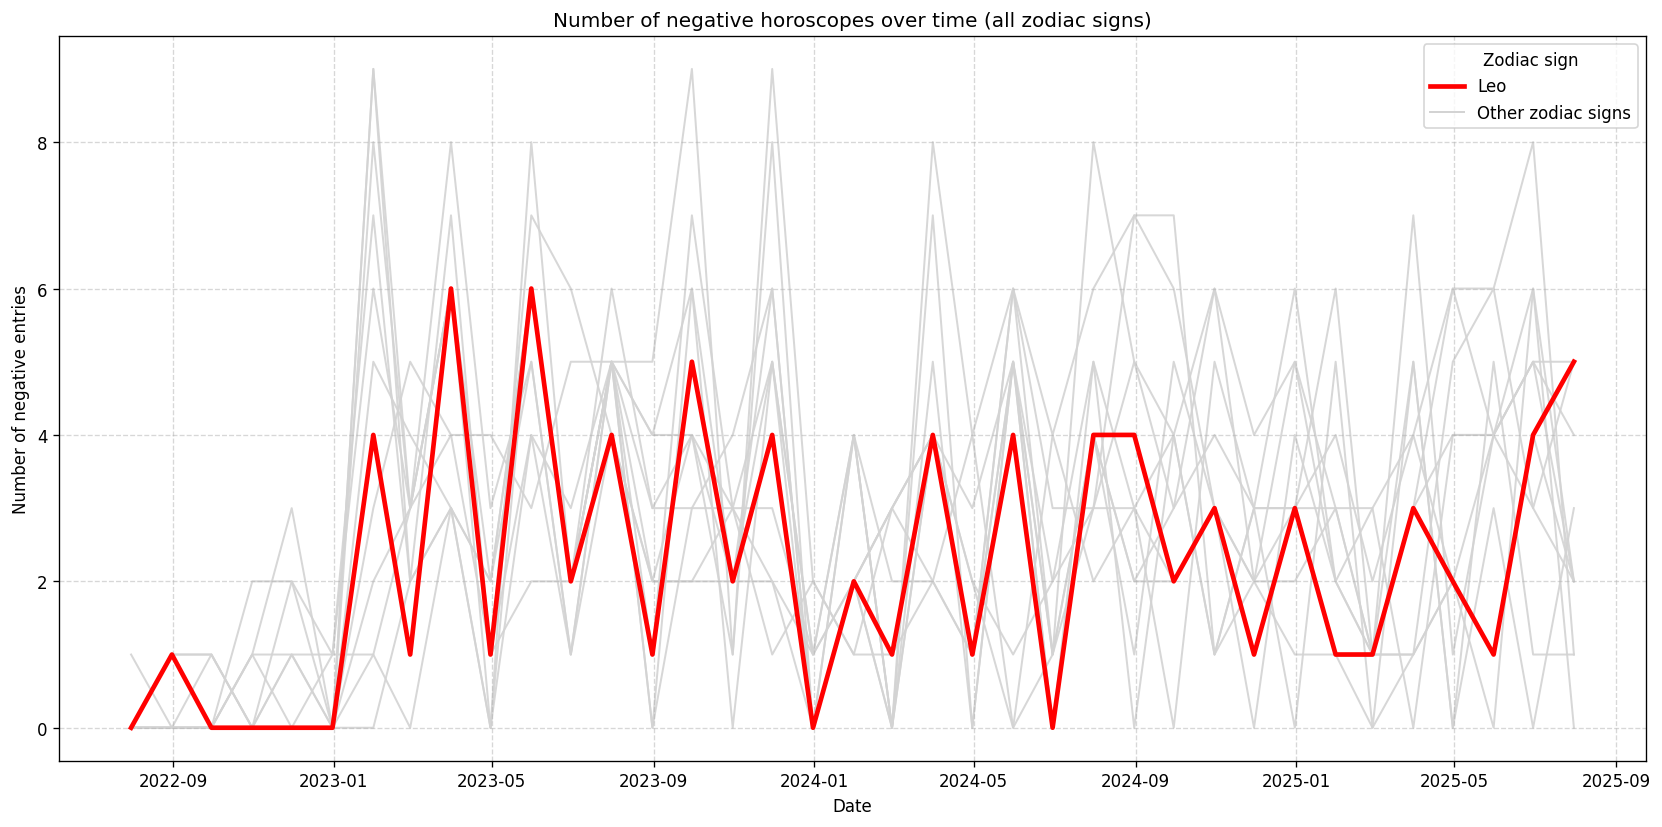

In [70]:
# Pivot & line chart 
pivot_df = grouped_neg.pivot(index="date", columns="source", values="liczba_negatywnych").fillna(0)

highlight_sign = "Leo"

plt.figure(figsize=(14, 7))

found = False
for col in pivot_df.columns:
    if str(col).lower() == highlight_sign.lower():
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=2.8, color='red', zorder=3, label=str(col)
        )
        found = True
    else:
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=1.2, color='lightgray', alpha=0.9, zorder=1
        )

plt.title("Number of negative horoscopes over time (all zodiac signs)")
plt.xlabel("Date")
plt.ylabel("Number of negative entries")
plt.grid(True, linestyle="--", alpha=0.5)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2.8, label=highlight_sign),
    Line2D([0], [0], color='lightgray', linewidth=1.2, label='Other zodiac signs')
]
plt.legend(handles=legend_elements, title="Zodiac sign")

plt.tight_layout()
plt.savefig("leo_vs_other_signs_negative.png", dpi=300) 
plt.show()


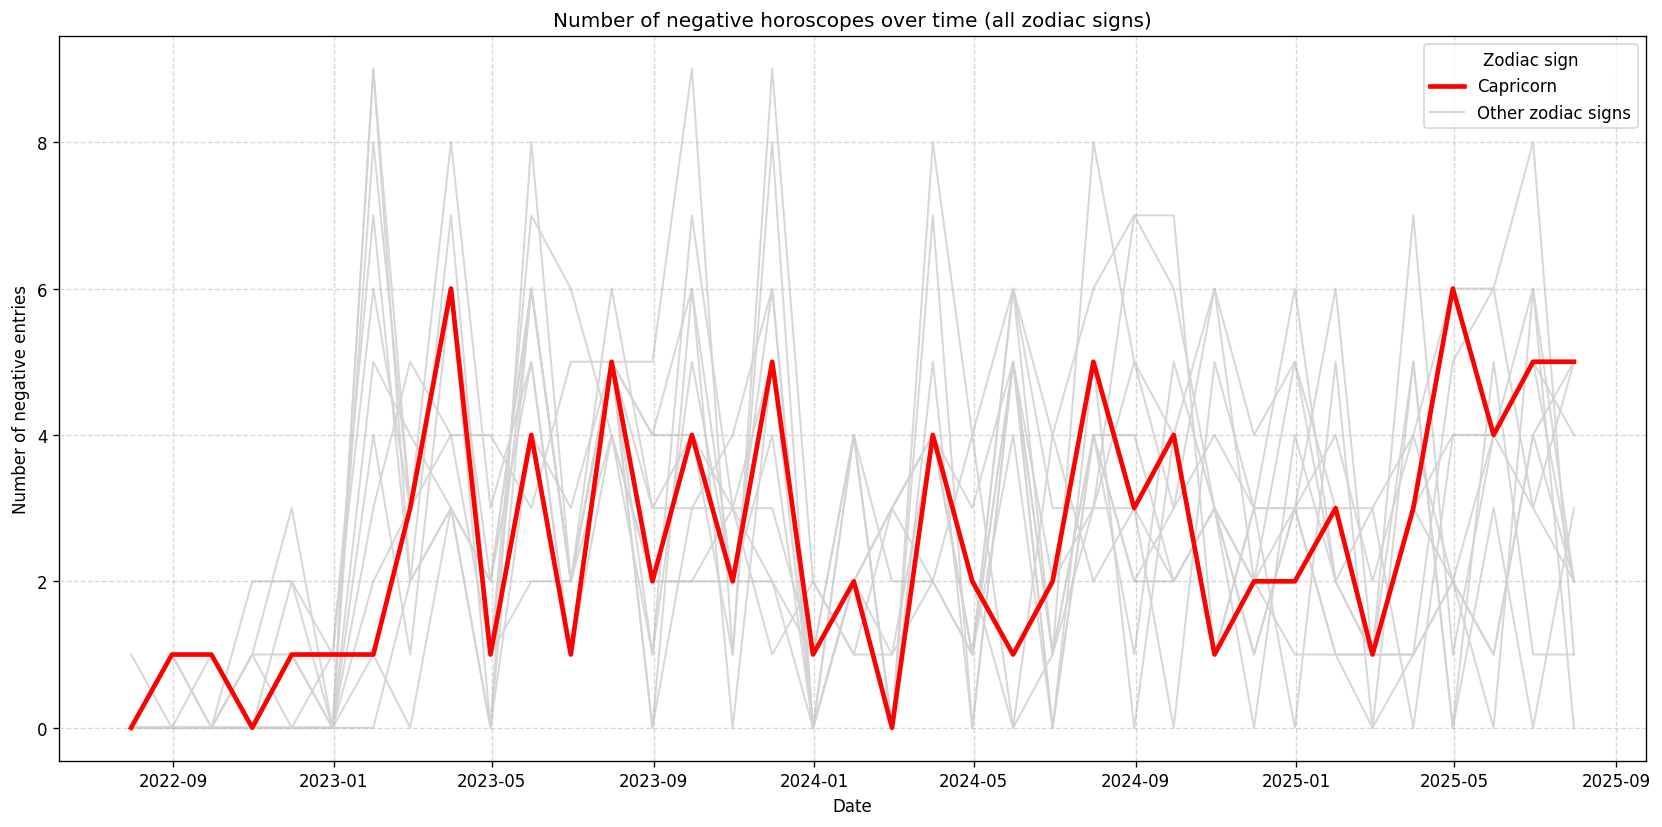

In [72]:
# Pivot & line chart 
pivot_df = grouped_neg.pivot(index="date", columns="source", values="liczba_negatywnych").fillna(0)

highlight_sign = "Capricorn"  # jeśli używasz polskich nazw, zmień na "Lew"

plt.figure(figsize=(14, 7))

found = False
for col in pivot_df.columns:
    if str(col).lower() == highlight_sign.lower():
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=2.8, color='red', zorder=3, label=str(col)
        )
        found = True
    else:
        plt.plot(
            pivot_df.index, pivot_df[col],
            linestyle='-', linewidth=1.2, color='lightgray', alpha=0.9, zorder=1
        )

plt.title("Number of negative horoscopes over time (all zodiac signs)")
plt.xlabel("Date")
plt.ylabel("Number of negative entries")
plt.grid(True, linestyle="--", alpha=0.5)

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2.8, label=highlight_sign),
    Line2D([0], [0], color='lightgray', linewidth=1.2, label='Other zodiac signs')
]
plt.legend(handles=legend_elements, title="Zodiac sign")

plt.tight_layout()
plt.savefig("capricorn_vs_other_signs_negative.png", dpi=300) 
plt.show()

In [109]:
df_concat

,date,horoscope,translated_text,sentiment_score,sentiment_label,hf_sentiment,source,hf_sentiment_full
0,2022-07-28,Ryby spełnią swoje marzenia i pragnienia. Nie ...,Fish will fulfill their dreams and desires. Yo...,0.9734,positive,POS,Pisces,positive
1,2022-07-29,Ryby od rana będą pełne sił i energii. Dzień s...,Fish will be full of strength and energy from ...,0.9451,positive,POS,Pisces,positive
2,2022-07-30,Ryby poczują się trochę osłabione. Dzień nie s...,Fish will feel a little weakened. The day is n...,-0.7004,negative,NEG,Pisces,negative
3,2022-07-31,Ryby będą niechętnie nowym sprawom i znajomośc...,Fish will be reluctant to new matters and acqu...,-0.2431,negative,NEU,Pisces,neutral
4,2022-08-01,Ryby ogarnie buntowniczy nastrój. Pod byle pre...,The fish will embrace the rebellious mood. Und...,0.9516,positive,POS,Pisces,positive
...,...,...,...,...,...,...,...,...
13075,2025-07-22,"Koziorożcu, pamiętaj, że lepsza jest szczera p...","Capricorn, remember that honest truth is bette...",0.9571,positive,POS,Capricorn,positive
13076,2025-07-23,"Koziorożcu, poczujesz się dziś nieco osamotnio...","Capricorn, you will feel a bit lonely today. T...",-0.4621,negative,NEU,Capricorn,neutral
13077,2025-07-24,"Koziorożcu, nie przejmuj się opiniami innych i...","Capricorn, do not worry about the opinions of ...",0.0767,positive,POS,Capricorn,positive
13078,2025-07-25,"Koziorożcu, dziś będziesz bardzo ciekawski, a ...","Capricorn, today you will be very curious, and...",-0.3723,negative,NEG,Capricorn,negative


In [111]:
df_concat["hf_sentiment"] = df_concat["hf_sentiment"].map({
    "POS": 0,
    "NEG": 1,
    "NEU": 0
})


📊 Contingency table (group vs. is_negative):
hf_sentiment   0.0  1.0
source                 
Aquarius       996   93
Aries         1012   78
Cancer         966  124
Capricorn      994   94
Gemini        1002   88
Leo           1007   83
Libra          991   99
Pisces         994   96
Sagittarius    973  116
Scorpio       1007   83
Taurus         953  137
Virgo         1007   82


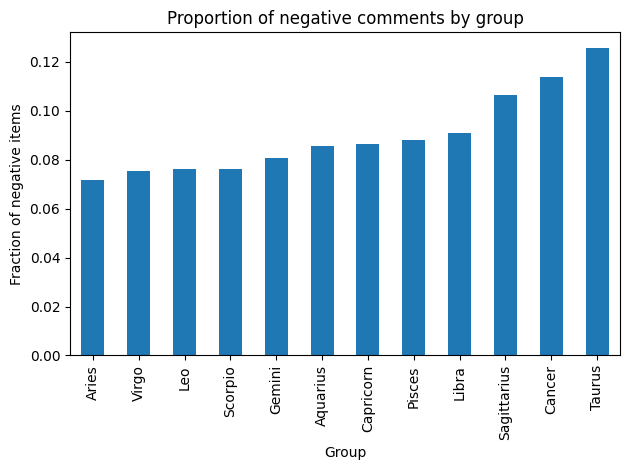


🔬 Chi-square test:
Chi2 = 42.365, df = 11, p-value = 0.0000
❗ There is a statistically significant difference in the proportion of negative comments between groups.


In [43]:
# col: 'grupa', 'is_negative' (1 = negative, 0 = no)

# Contingency table: counts of negative and non-negative comments in each group
contingency = pd.crosstab(df_concat['source'], df_concat['hf_sentiment'])

# Show Table
print("\n📊 Contingency table (group vs. is_negative):")
print(contingency)

# Test Chi-square
chi2, pval, dof, expected = chi2_contingency(contingency)

# Wizualizacja proporcji negatywnych komentarzy
proportions = df_concat.groupby('source')['hf_sentiment'].mean().sort_values()
proportions.plot(kind='bar', title='Proportion of negative comments by group')
plt.ylabel('Fraction of negative items')
plt.xlabel('Group')
plt.tight_layout()
plt.show()

# Results
print(f"\n🔬 Chi-square test:")
print(f"Chi2 = {chi2:.3f}, df = {dof}, p-value = {pval:.4f}")

# Interpretation
if pval < 0.05:
    print("❗ There is a statistically significant difference in the proportion of negative comments between groups.")
else:
    print("✅ There is no basis to reject the null hypothesis — the proportions are similar.")


In [51]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))


📊 Contingency table (full set):
hf_sentiment     0    1
source                 
Aquarius       996   93
Aries         1012   78
Cancer         966  124
Capricorn      994   94
Gemini        1002   88
Leo           1007   83
Libra          991   99
Pisces         994   96
Sagittarius    973  116
Scorpio       1007   83
Taurus         953  137
Virgo         1007   82

🔬 Chi-square test (full set):
Chi2 = 42.365, df = 11, p-value = 0.000014


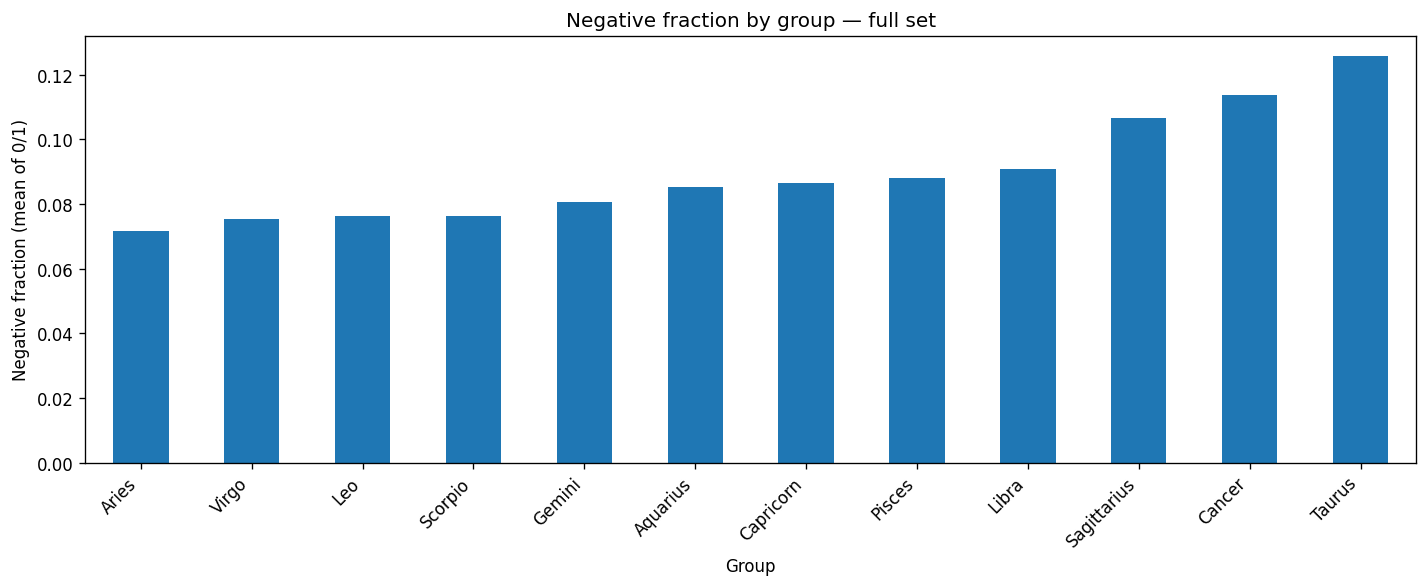


ℹ️ Records in group 'Taurus': 1090

📊 Contingency table (without Taurus):
hf_sentiment     0    1
source                 
Aquarius       996   93
Aries         1012   78
Cancer         966  124
Capricorn      994   94
Gemini        1002   88
Leo           1007   83
Libra          991   99
Pisces         994   96
Sagittarius    973  116
Scorpio       1007   83
Virgo         1007   82

🔬 Chi-square test (without Taurus):
Chi2 = 24.323, df = 10, p-value = 0.006787


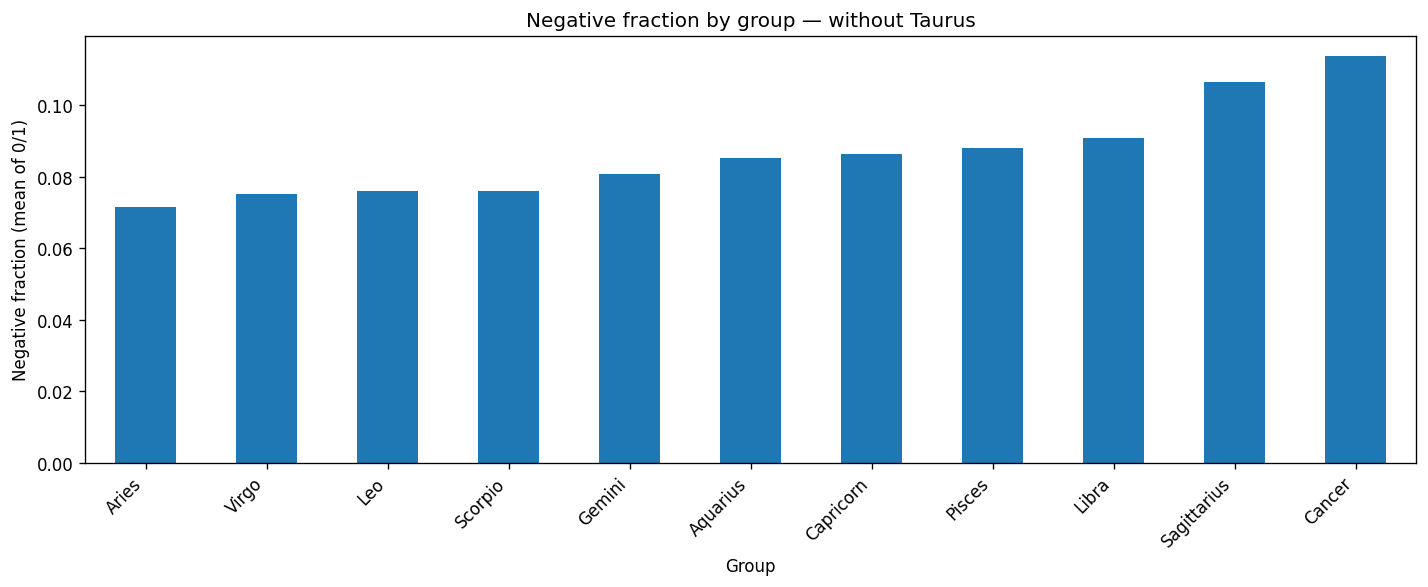


ℹ️ Records in group 'Cancer' (after removing Taurus): 1090

📊 Contingency table (without Taurus & Cancer):
hf_sentiment     0    1
source                 
Aquarius       996   93
Aries         1012   78
Capricorn      994   94
Gemini        1002   88
Leo           1007   83
Libra          991   99
Pisces         994   96
Sagittarius    973  116
Scorpio       1007   83
Virgo         1007   82

🔬 Chi-square test (without Taurus & Cancer):
Chi2 = 13.374, df = 9, p-value = 0.146389


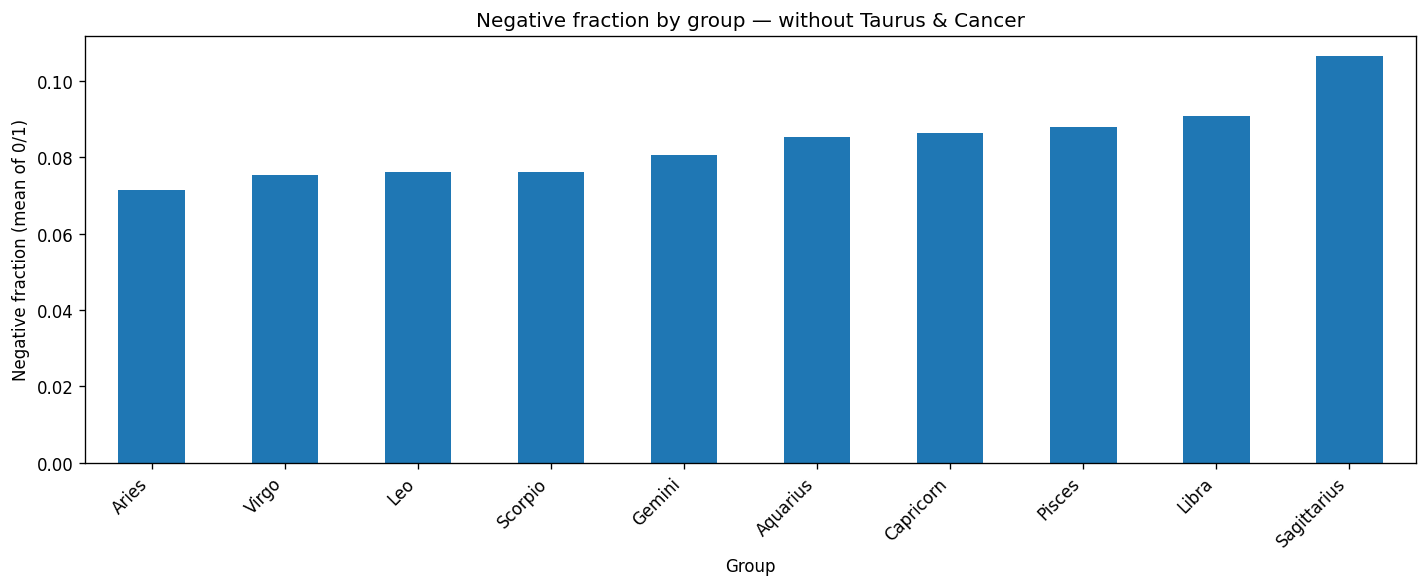


🔁 Does the conclusion stay the same after removing Taurus?
YES — conclusion stays the same.
(full set p-value: 0.000014 | without Taurus p-value: 0.006787 → significant (p < 0.05))

🔁 Does the conclusion stay the same after additionally removing Cancer?
NO — the conclusion changed.
(without Taurus p-value: 0.006787 | without Taurus & Cancer p-value: 0.146389 → not significant (p ≥ 0.05))


In [55]:
# --- Auto-detect column names (adapts to your dataframe) ---
group_col = 'source' if 'source' in df_concat.columns else 'grupa'
neg_col   = 'hf_sentiment' if 'hf_sentiment' in df_concat.columns else 'is_negative'

def chi2_test_report(df, label):
    # Ensure we have both 0/1 categories in columns
    ct = pd.crosstab(df[group_col], df[neg_col]).reindex(columns=[0, 1], fill_value=0)

    print(f"\n📊 Contingency table ({label}):")
    print(ct)

    if ct.shape[0] < 2 or ct.shape[1] < 2:
        print("⚠️ Not enough categories for chi-square test (need ≥ 2 groups and 2 outcome categories).")
        return None

    chi2, pval, dof, expected = chi2_contingency(ct)

    print(f"\n🔬 Chi-square test ({label}):")
    print(f"Chi2 = {chi2:.3f}, df = {dof}, p-value = {pval:.6f}")

    # Visualization: fraction of negatives (mean of 0/1)
    proportions = df.groupby(group_col)[neg_col].mean().sort_values()
    ax = proportions.plot(kind='bar', title=f'Negative fraction by group — {label}')
    plt.ylabel('Negative fraction (mean of 0/1)')
    plt.xlabel('Group')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return {'chi2': chi2, 'pval': pval, 'dof': dof, 'ct': ct}

# --- 1) Full dataset ---
base = chi2_test_report(df_concat, 'full set')

# --- 2) Remove Taurus ---
n_taurus = (df_concat[group_col] == 'Taurus').sum()
print(f"\nℹ️ Records in group 'Taurus': {n_taurus}")

df_no_taurus = df_concat[df_concat[group_col] != 'Taurus'].copy()

# --- 3) Dataset without Taurus ---
reduced_taurus = chi2_test_report(df_no_taurus, 'without Taurus')

# --- 4) Additionally remove Cancer (next sign) ---
n_cancer_after_taurus = (df_no_taurus[group_col] == 'Cancer').sum()
print(f"\nℹ️ Records in group 'Cancer' (after removing Taurus): {n_cancer_after_taurus}")

df_no_taurus_cancer = df_no_taurus[df_no_taurus[group_col] != 'Cancer'].copy()

# --- 5) Dataset without Taurus & Cancer ---
reduced_taurus_cancer = chi2_test_report(df_no_taurus_cancer, 'without Taurus & Cancer')

# --- 6) Compare conclusions ---
def conclusion(p): 
    return "significant (p < 0.05)" if p < 0.05 else "not significant (p ≥ 0.05)"

if base is not None and reduced_taurus is not None:
    same1 = (base['pval'] < 0.05) == (reduced_taurus['pval'] < 0.05)
    ans1 = "YES — conclusion stays the same." if same1 else "NO — the conclusion changed."
    print("\n🔁 Does the conclusion stay the same after removing Taurus?")
    print(ans1)
    print(f"(full set p-value: {base['pval']:.6f} | without Taurus p-value: {reduced_taurus['pval']:.6f} "
          f"→ {conclusion(reduced_taurus['pval'])})")
else:
    print("\n⚠️ Could not compare conclusions for 'full set' vs 'without Taurus'.")

if reduced_taurus is not None and reduced_taurus_cancer is not None:
    same2 = (reduced_taurus['pval'] < 0.05) == (reduced_taurus_cancer['pval'] < 0.05)
    ans2 = "YES — conclusion stays the same." if same2 else "NO — the conclusion changed."
    print("\n🔁 Does the conclusion stay the same after additionally removing Cancer?")
    print(ans2)
    print(f"(without Taurus p-value: {reduced_taurus['pval']:.6f} | without Taurus & Cancer p-value: "
          f"{reduced_taurus_cancer['pval']:.6f} → {conclusion(reduced_taurus_cancer['pval'])})")
else:
    print("\n⚠️ Could not compare conclusions for 'without Taurus' vs 'without Taurus & Cancer'.")

In [113]:
import numpy as np
from sentence_transformers import SentenceTransformer, util
import seaborn as sns
import matplotlib.pyplot as plt

In [115]:
# Sample 10 horoscopes
sample_df = df_concat['translated_text'].dropna().sample(10).reset_index(drop=True)

In [119]:
sample_df

0    Bull, take care of rest, you can feel a bit ti...
1    Fish without enthusiasm will approach family e...
2    He will gather for returns to the past. It is ...
3    Aquarius will be very sociable today. They dec...
4    Fish, the beginning of the week will be extrem...
5    All Poland for bikes, and you are not? Maybe k...
6    Scorpio, today after turning at work, spend on...
7    Capricorn, today you may not feel like anythin...
8    Scorpions will gladly deal with cooking or cle...
9    Bull, do something you have felt like for a lo...
Name: translated_text, dtype: object

In [121]:
# Load the model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Generate embeddings for the horoscopes
embeddings = model.encode(sample_df.tolist(), convert_to_tensor=True)

In [123]:
# Compute the cosine similarity matrix
similarity_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

# Labels: e.g., the first five words of each horoscope
labels = [text[:40] + '...' for text in sample_df]  

In [125]:
# Create the similarity matrix as a DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=labels, columns=labels)

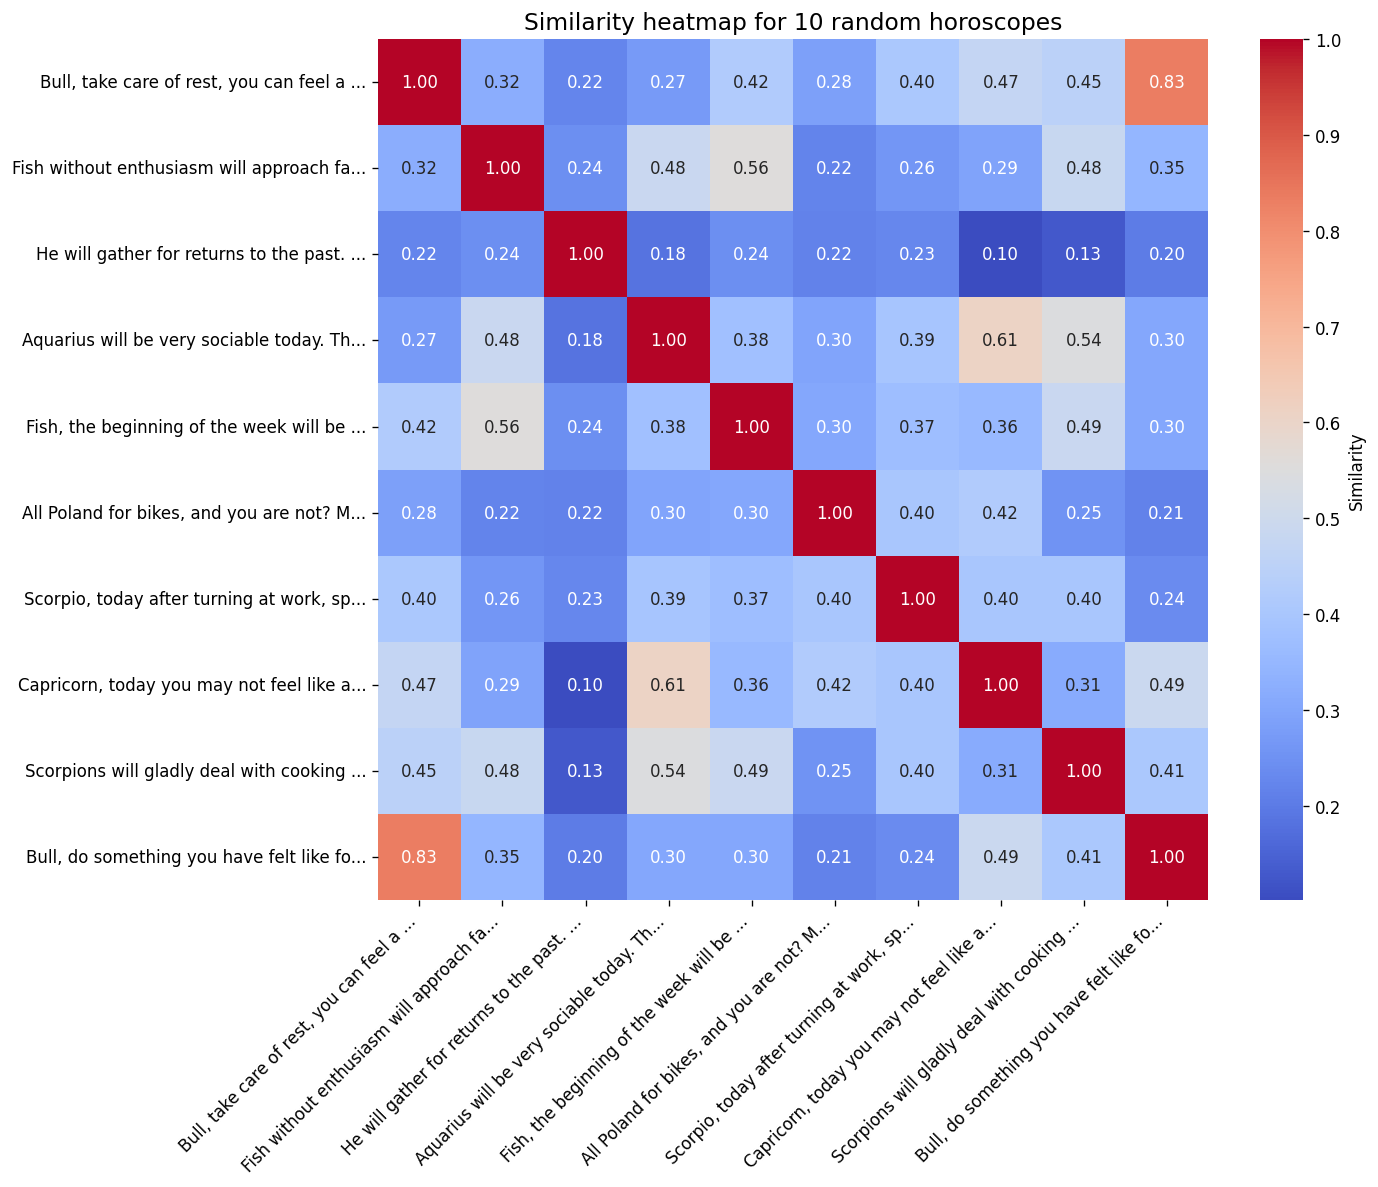

In [127]:
# Create Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Similarity'})
plt.title("Similarity heatmap for 10 random horoscopes", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [129]:
from itertools import combinations

In [133]:
# Find the top 5 most similar pairs (excluding the diagonal and duplicates)
pairs = list(combinations(range(len(sample_df)), 2))

pair_scores = []
for i, j in pairs:
    pair_scores.append({
        'index_1': i,
        'index_2': j,
        'similarity': similarity_matrix[i][j],
        'horoscope_1': sample_df[i],
        'horoscope_2': sample_df[j]
    })

# Sort in descending order by similarity and select the top 5
top_pairs = sorted(pair_scores, key=lambda x: x['similarity'], reverse=True)[:3]

# List the similar pairs
print("\n🔝 Top 3 most similar pairs of horoscopes:\n")
for idx, pair in enumerate(top_pairs, 1):
    print(f"📌 Pair {idx} — Similarity: {pair['similarity']:.3f}")
    print(f"Horoscope 1:\n{pair['horoscope_1']}")
    print(f"Horoscope 2:\n{pair['horoscope_2']}")
    print("-" * 80)


🔝 Top 3 most similar pairs of horoscopes:

📌 Pair 1 — Similarity: 0.832
Horoscope 1:
Bull, take care of rest, you can feel a bit tired lately. Think about massage, make a home spa and focus on your pleasures. Thanks to this you will feel much better!
Horoscope 2:
Bull, do something you have felt like for a long time. This will improve your mood and give you confidence. Also try to leave your comfort zone as often as possible.
--------------------------------------------------------------------------------
📌 Pair 2 — Similarity: 0.607
Horoscope 1:
Aquarius will be very sociable today. They decide to visit friends, write a few letters and call your long -hearted friends. However, you will be more undecided than usual and therefore it is better to avoid risky decisions. The characters favorable for you are Scorpio and Capricorn.
Horoscope 2:
Capricorn, today you may not feel like anything. Try to make at least a minimum plan. In addition, physical activity should do you well. If you have

In [167]:
# Complete set of horoscopes
all_texts = df_concat['translated_text'].dropna().reset_index(drop=True)

# Horoskop, który chcesz porównać – np. pierwszy z próbki
query_text = sample_df[1]

In [169]:
query_text

'Fish without enthusiasm will approach family events. They will be more likely to finish old matters, read the book and watch the series. In the evening it is worth meeting someone close. The characters favorable for you are a bull and weight.'

In [171]:
# Load the model
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

In [172]:
# Embeddings
query_embedding = model.encode(query_text, convert_to_tensor=True)
all_embeddings = model.encode(all_texts.tolist(), convert_to_tensor=True)

In [173]:
# Calculate similarities
cosine_scores = util.cos_sim(query_embedding, all_embeddings)[0].cpu().numpy()

# Create DataFrame with results
results_df = pd.DataFrame({
    'text': all_texts,
    'similarity': cosine_scores
})

# Remove the self-match (i.e., the case where a horoscope is compared with itself)
results_df = results_df[results_df['text'] != query_text]

In [174]:
# Select the top 5 most similar
top_similar = results_df.sort_values(by='similarity', ascending=False).head(5)

# Show
print(f"\n🔍 Target horoscope:\n{query_text}\n")
print("🔝 Top 5 most similar horoscopes:\n")
for idx, row in top_similar.iterrows():
    print(f"✅ Similarity: {row['similarity']:.3f}")
    print(row['text'])
    print("-" * 80)


🔍 Target horoscope:
Fish without enthusiasm will approach family events. They will be more likely to finish old matters, read the book and watch the series. In the evening it is worth meeting someone close. The characters favorable for you are a bull and weight.

🔝 Top 5 most similar horoscopes:

✅ Similarity: 0.761
Fish will have a good mood. They will receive a lot of good news, primarily from their beloved people. In the afternoon it is worth going somewhere with friends and not thinking about any problems. The characters that are favorable for you are a ram and a shooter.
--------------------------------------------------------------------------------
✅ Similarity: 0.761
Fish will have a good mood. They will receive a lot of good news, primarily from their beloved people. In the afternoon it is worth going somewhere with friends and not thinking about any problems. The characters that are favorable for you are a ram and a shooter.
--------------------------------------------------